# ARIMA
**Content:**
- Google Colab Setup
- Preprocessing
- Stationary check + Decomposition plot
- Modeling

In [1]:
# util.py has pmdarima function inside
# Need to install it before import the pyfile
# !pip install pmdarima

In [2]:
# Need to re-install statsmodels version to 0.11 !!!
# (pmdarima 1.8.2 has requirement statsmodels version >=0.11 while some of the statsmodels code were deprecated in 0.12)
# !pip install statsmodels==0.11

## I. Google Colab Setup

In [3]:
# Google Colab
from google.colab import drive
import os

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score

# pmdarima
import pmdarima as pm
from pmdarima.arima import decompose
from pmdarima.utils import decomposed_plot
from pmdarima.arima.stationarity import ADFTest
from pmdarima.arima.utils import ndiffs
from pmdarima import model_selection

# statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults

In [4]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [5]:
# Get the current working directory
print(os.getcwd())

/content


In [6]:
# Drive path is the path where I upload the ETFs history file
drive_path_csv = '/gdrive/MyDrive/Capstone_Project/REIT_ETFs.csv'
drive_path_util = '/gdrive/MyDrive/Capstone_Project/util.py'

# Expect to move the file into the local path
local_path = '/content'

In [7]:
# Copy the file in drive path
!cp '{drive_path_csv}' .
!cp '{drive_path_util}' .

# Change the file from drive path to the local path
os.chdir(local_path)

In [8]:
import util as ut

## II. Preprocessing

In [9]:
data = pd.read_csv('/content/REIT_ETFs.csv')
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
1,2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2,2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
3,2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
4,2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...,...
53434,2021-06-17,9.280000,9.290000,9.220000,9.220000,5200,0.0,0.0,REK
53435,2021-06-18,9.330000,9.370000,9.270000,9.370000,22800,0.0,0.0,REK
53436,2021-06-21,9.320000,9.320000,9.170000,9.170000,22900,0.0,0.0,REK
53437,2021-06-22,9.160000,9.230000,9.160000,9.220000,6200,0.0,0.0,REK


In [10]:
# Select one REIT ETF
vnq = data.copy().loc[data['Ticker'] == "VNQ"]

In [11]:
# Set the "Date" column as the index
ut.preprocess_df(vnq)

This dataframe's index is in datatime64? True


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
Date,,,,,,,,
2004-09-29,23.794544,23.861371,23.789772,23.794544,205800,0.0,0.0,VNQ
2004-09-30,23.866143,24.023660,23.861370,23.985474,27900,0.0,0.0,VNQ
2004-10-01,24.033207,24.462799,23.985476,24.429386,129800,0.0,0.0,VNQ
2004-10-04,24.529629,24.606000,24.529629,24.534403,8100,0.0,0.0,VNQ
2004-10-05,24.534403,24.582135,24.510535,24.529629,11900,0.0,0.0,VNQ
...,...,...,...,...,...,...,...,...
2021-06-17,103.410004,103.699997,102.860001,103.550003,5055100,0.0,0.0,VNQ
2021-06-18,103.019997,103.470001,101.790001,101.790001,5358000,0.0,0.0,VNQ
2021-06-21,102.309998,104.209999,101.800003,103.889999,3672900,0.0,0.0,VNQ


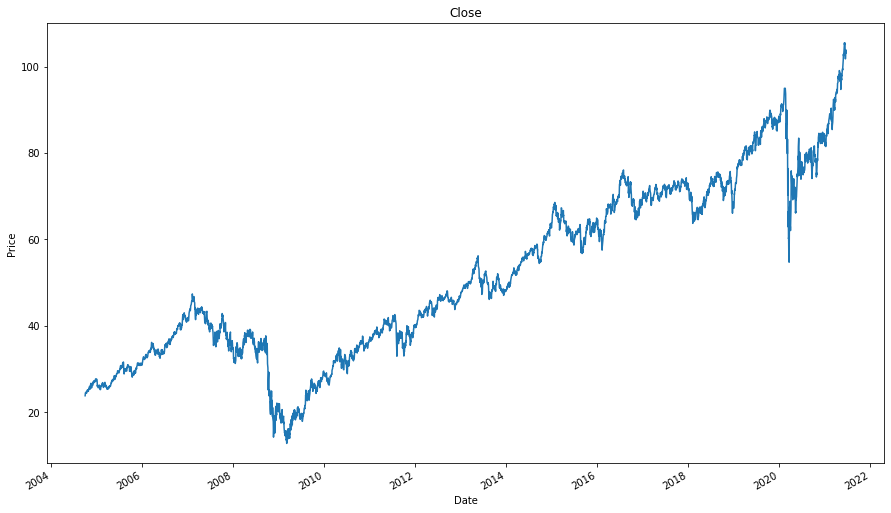

In [12]:
# Original time series
ut.visualize_time_series(vnq['Close'])

### Stationary Check + Decomposition Plot

- number of trading days in a year: 253
- number of trading days in a month: 21

https://en.wikipedia.org/wiki/Trading_day

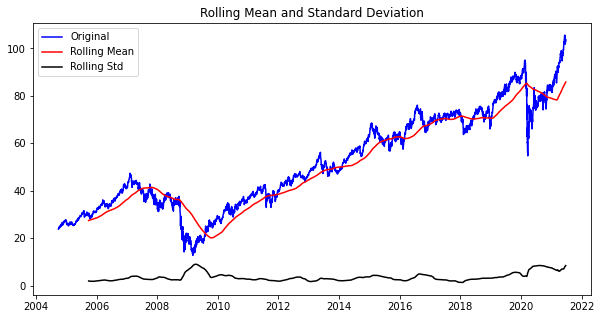

Non-stationary, because p ≥ 0.05 

Results of Dickey-Fuller test: 

Test Statistic                    0.206874
p-value                           0.972645
#Lags Used                       29.000000
Number of Observations Used    4183.000000
Critical Value (1%)              -3.431914
Critical Value (5%)              -2.862231
Critical Value (10%)             -2.567138
dtype: float64


In [13]:
ut.stationary_check_statsmodels(vnq['Close'], 253)

In [14]:
ut.stationary_check_pmdarima(vnq['Close'])

P-Value: 0.3360275927619048, so should you difference the data? True


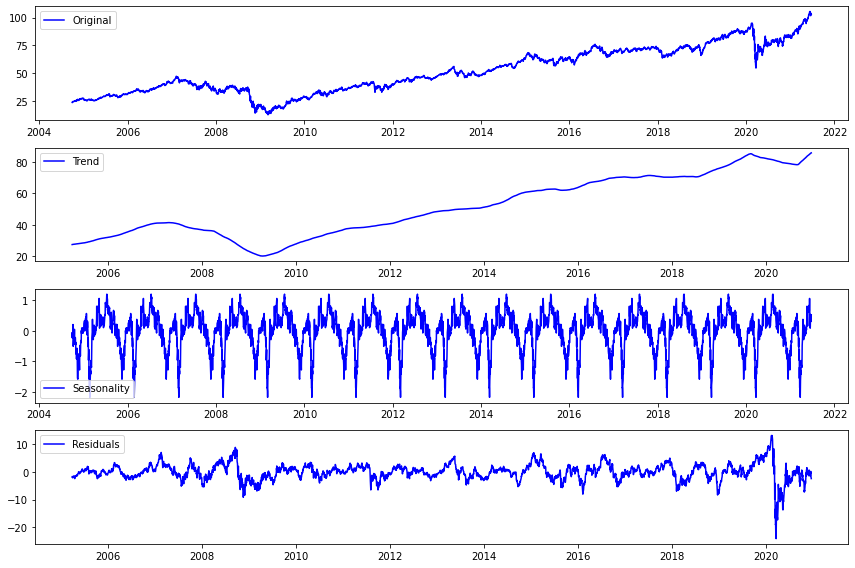

In [15]:
ut.decomposition_plot_statsmodels(vnq['Close'], 253)

- Seasonality is very small

### Detrend (differencing)
- estimate ARIMA [differencing term](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ndiffs.html)

In [16]:
adf_diffs = ndiffs(vnq['Close'], alpha=0.05,  test='adf', max_d=10)

print(f"Estimated differencing term: {adf_diffs}")

Estimated differencing term: 1


In [17]:
diff_ts = ut.detrend_differencing(vnq['Close'], periods=1)

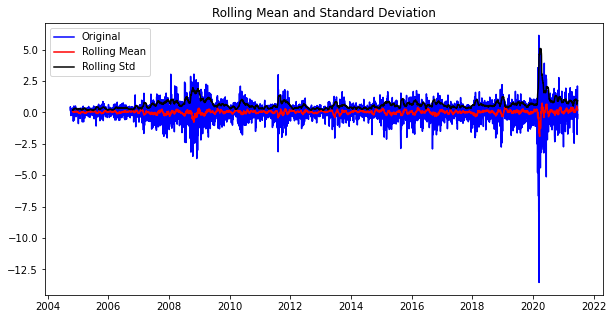

Stationary, because p < 0.05 

Results of Dickey-Fuller test: 

Test Statistic                -1.349919e+01
p-value                        3.000131e-25
#Lags Used                     2.800000e+01
Number of Observations Used    4.183000e+03
Critical Value (1%)           -3.431914e+00
Critical Value (5%)           -2.862231e+00
Critical Value (10%)          -2.567138e+00
dtype: float64


In [18]:
ut.stationary_check_statsmodels(diff_ts, 21)

### ACF & PACF

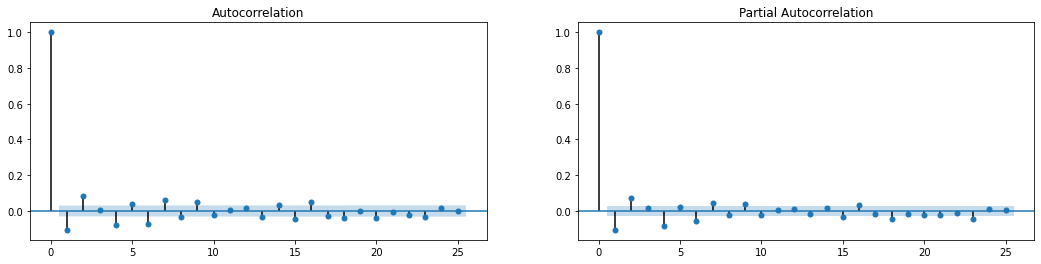

In [19]:
ut.plot_ACF_PACF(diff_ts)

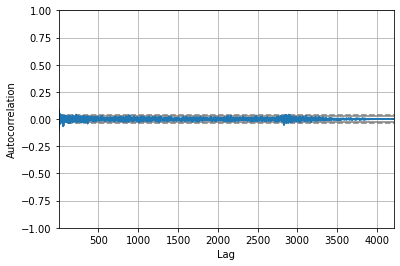

In [20]:
ut.pd_ACF(diff_ts)

## III. Modeling

In [21]:
# Split the data into train, validation, and test set

train = vnq['Close'].iloc[:-274]   # Train size = rest of the time
val = vnq['Close'].iloc[-274:-21]  # Val size = 1 year (253 days)
test = vnq['Close'].iloc[-21:]     # Test size = 1 month (21 days)

# train, test = model_selection.train_test_split(vnq['Close'], test_size=253)

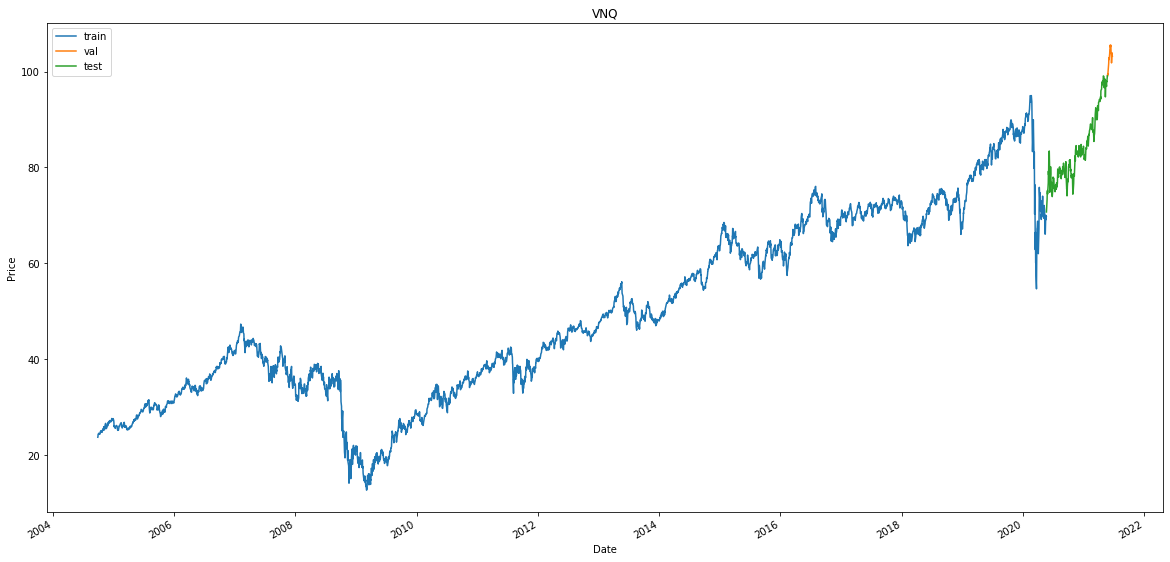

In [22]:
ut.visualize_train_val_test(train, test, val, "VNQ")

[pmdarima.auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)
- m = 4 quarterly
- m = 12 monthly
- m = 1 annually

In [23]:
# Use pmdarima to find the optimal p, d, q, and P, D, Q
arima_pmd = pm.auto_arima(train,
                          d=1,
                          max_p=2,
                          max_q=2,
                          error_action='ignore', 
                          trace=True,
                          suppress_warnings=True, 
                          maxiter=100,
                          seasonal=True,
                          m=1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8833.108, Time=3.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8933.547, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8872.792, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8882.249, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8932.497, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=8841.707, Time=1.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8849.974, Time=2.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8863.534, Time=1.48 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=8832.107, Time=1.29 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=8840.684, Time=0.67 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=8848.984, Time=0.84 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8862.711, Time=0.49 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 13.196 seconds


- [statsmodels arima](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
- [forecast](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARMAResults.forecast.html)
- [example](https://dataplatform.cloud.ibm.com/exchange/public/entry/view/1835c567cd309d54fc797900f79a60f9)
- [SARIMAX](https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/)

In [24]:
arima_order = arima_pmd.order
arima_order

(2, 1, 2)

In [25]:
# Change the train values into a list
history = [x for x in train] 

pred = [] # prediction
cf_left = [] # confidence interval: lower bound
cf_right = [] # confidence interval: upper bound


for t in range(len(val)):
    # Fit the model using statsmodels library
    arima = ARIMA(history, order=arima_order).fit()

    # Make prediction
    forecast, stderr, conf_int = arima.forecast()
    
    # Predicted price
    prediction = forecast
    pred.append(prediction)
    
    # Confidence interval
    cf_left.append(conf_int[0][0])
    cf_right.append(conf_int[0][1])
    
    # Actual price
    actual = val[t]
    history.append(actual)
    print('predicted=%f, expected=%f' % (prediction, actual))

predicted=69.690508, expected=70.730103
predicted=70.651126, expected=73.373955
predicted=73.213623, expected=74.835274
predicted=74.979232, expected=75.190994
predicted=75.368967, expected=74.441109
predicted=74.522606, expected=76.162003
predicted=75.844442, expected=76.777298
predicted=76.870035, expected=79.238480
predicted=79.153064, expected=78.450127
predicted=78.763980, expected=81.420860
predicted=81.048014, expected=83.439796
predicted=83.423470, expected=82.055382
predicted=82.570871, expected=79.969147
predicted=80.089287, expected=74.835274
predicted=75.018550, expected=77.517570
predicted=76.754468, expected=78.613564
predicted=78.652070, expected=80.161423
predicted=80.296081, expected=78.998138
predicted=78.811646, expected=78.132874
predicted=78.628327, expected=76.998421
predicted=77.078171, expected=76.921509
predicted=77.312293, expected=76.604248
predicted=76.340527, expected=74.421883
predicted=74.676599, expected=75.372398
predicted=75.065348, expected=73.925735


In [26]:
ut.evaluate(val, pred)

MAE: 0.8465
RMSE: 1.0951
R^2: 0.9753


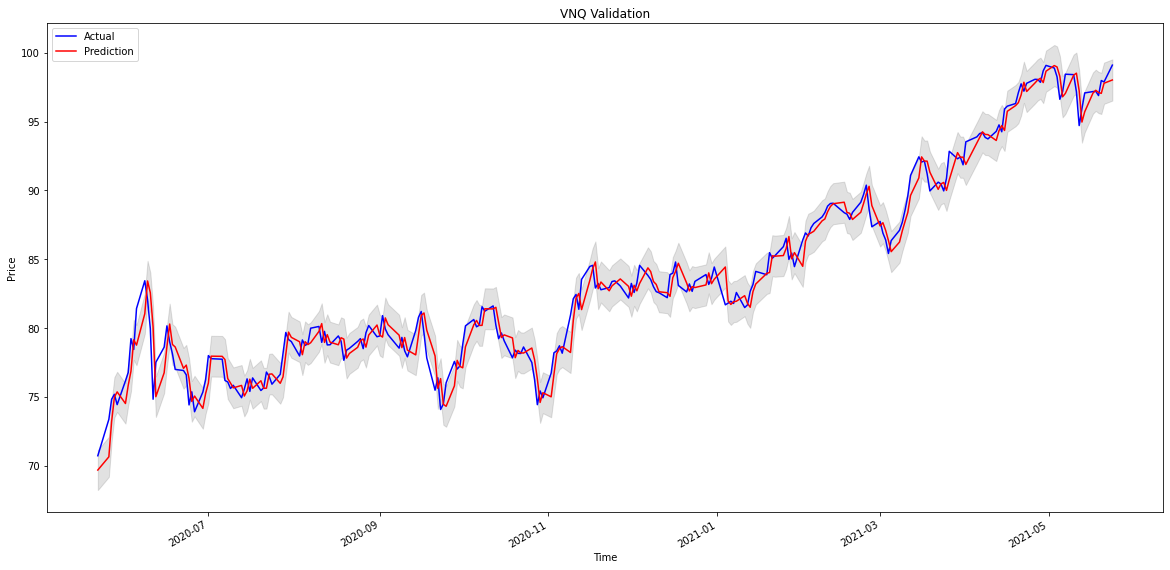

In [34]:
# Plot the prediction
ax = vnq.Close[val.index[0]:val.index[-1]].plot(figsize=(20,10), color='blue')

# Create a df for the predictions using same index as val part
df = pd.DataFrame(pred).set_index(val.index)
df.plot(ax=ax, color= 'red')

# Add the confidence interval for prediction
ax.fill_between(val.index, cf_left, cf_right, color='dimgray', alpha=0.2)

# Add the labels to the plot.
plt.legend(('Actual', 'Prediction'), loc=2)
plt.title("VNQ Validation")
plt.xlabel('Time')
plt.ylabel('Price')
plt.savefig('arima_val_result', dpi=300, bbox_inches='tight')
plt.show()

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://machinelearningmastery.com/save-arima-time-series-forecasting-model-python/

In [28]:
# Save the model
# arima.save('/content/arima_model.pkl')

# Load the model
# loaded = ARIMAResults.load('/content/arima_model.pkl')

## IV. Evaluation

In [29]:
# Make prediction on test set
fc, std, ci = arima.forecast(steps=21)

In [30]:
ut.evaluate(test.values, fc)

MAE: 4.7131
RMSE: 5.0823
R^2: -5.6888


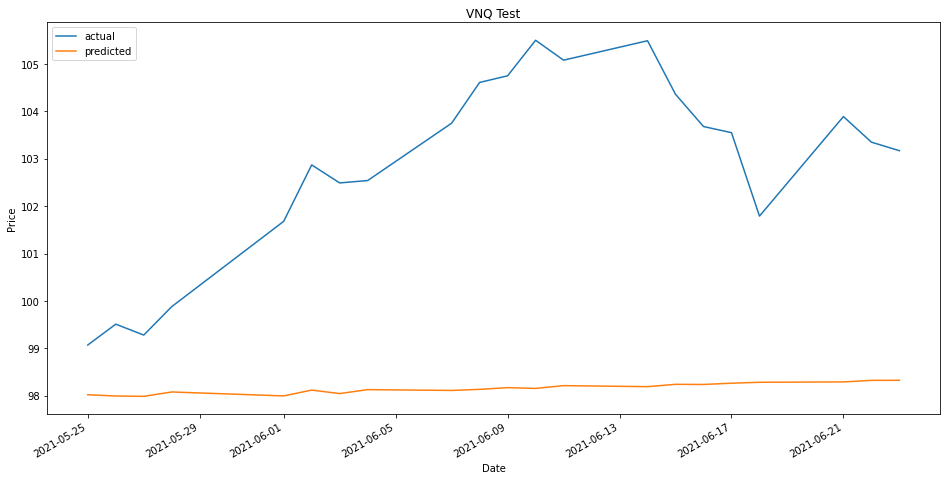

In [32]:
# Create a df to store the actual test and pred test results
test_df = pd.DataFrame(index=test.index,
                       columns=['actual', 'predicted'])

test_df['actual'] = test.values
test_df['predicted'] = fc

# Compare the actual and pred results
test_df.plot(figsize=(16,8))
plt.title("VNQ Test")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc=2)
plt.savefig('arima_test_result', dpi=300, bbox_inches='tight')
plt.show()